# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS-109B Introduction to Data Science
## Lab 5: Convolutional Neural Networks

**Harvard University**<br>
**Spring 2020**<br>
**Instructors:** Mark Glickman, Pavlos Protopapas, and Chris Tanner<br>
**Lab Instructors:** Chris Tanner and Eleni Angelaki Kaxiras<br>
**Content:** Eleni Angelaki Kaxiras, Pavlos Protopapas, Patrick Ohiomoba, and David Sondak

---

In [1]:
# RUN THIS CELL TO PROPERLY HIGHLIGHT THE EXERCISES
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2019-CS109B/master/content/styles/cs109.css").text
HTML(styles)

## Learning Goals

In this lab we will look at Convolutional Neural Networks (CNNs), and their building blocks.

By the end of this lab, you should:

- have a good undertanding on how images, a common type of data for a CNN, are represented in the computer and how to think of them as arrays of numbers. 
- be familiar with preprocessing images with `tf.keras` and `scipy`.
- know how to put together the building blocks used in CNNs - such as convolutional layers and pooling layers - in `tensorflow.keras` with an example. 
- run your first CNN.

In [2]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (5,5)

import numpy as np
from scipy.optimize import minimize
from sklearn.utils import shuffle
%matplotlib inline

In [3]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Input
from tensorflow.keras.layers import Conv2D, Conv1D, MaxPooling2D, MaxPooling1D,\
                                GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import AUC, Precision, Recall, FalsePositives, FalseNegatives, \
                                    TruePositives, TrueNegatives
from tensorflow.keras.regularizers import l2

In [4]:
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras
import tensorflow as tf

tf.keras.backend.clear_session()  # For easy reset of notebook state.

print(tf.__version__)  # You should see a > 2.0.0 here!


2.0.0


## Part 0: Running on SEAS JupyterHub

**PLEASE READ**: [Instructions for Using SEAS JupyterHub](https://canvas.harvard.edu/courses/65462/pages/instructions-for-using-seas-jupyterhub?module_item_id=638544)

SEAS and FAS are providing you with a platform in AWS to use for the class (accessible from the 'Jupyter' menu link in Canvas). These are AWS p2 instances with a GPU, 10GB of disk space, and 61 GB of RAM,  for faster training for your networks. Most of the libraries such as keras, tensorflow, pandas, etc. are pre-installed. If a library is missing you may install it via the Terminal.

**NOTE : The AWS platform is funded by SEAS and FAS for the purposes of the class. It is not running against your individual credit.**

**NOTE NOTE NOTE: You are not allowed to use it for purposes not related to this course.**

**Help us keep this service: Make sure you stop your instance as soon as you do not need it.**

![aws-dog](../images/aws-dog.jpeg)
*source:CS231n Stanford: Google Cloud Tutorial*

## Part 1: Parts of a Convolutional Neural Net

We can have 
- 1D CNNs which are useful for time-series or 1-Dimensional data, 
- 2D CNNs used for 2-Dimensional data such as images, and also 
- 3-D CNNs used for video.

### a. Convolutional Layers.

Convolutional layers are comprised of **filters** and **feature maps**. The filters are essentially the **neurons** of the layer. They have the weights and produce the input for the next layer. The feature map is the output of one filter applied to the previous layer. 

Convolutions operate over 3D tensors, called feature maps, with two spatial axes (height and width) as well as a depth axis (also called the channels axis). For an RGB image, the dimension of the depth axis is 3, because the image has three color channels: red, green, and blue. For a black-and-white picture, like the MNIST digits, the depth is 1 (levels of gray). The convolution operation extracts patches from its input feature map and applies the same transformation to all of these patches, producing an output feature map. This output feature map is still a 3D tensor: it has a width and a height. Its depth can be arbitrary, because the output depth is a parameter of the layer, and the different channels in that depth axis no longer stand for specific colors as in RGB input; rather, they stand for filters. Filters encode specific aspects of the input data: at a high level, a single filter could encode the concept “presence of a face in the input,” for instance.

In the MNIST example that we will see, the first convolution layer takes a feature map of size (28, 28, 1) and outputs a feature map of size (26, 26, 32): it computes 32 filters over its input. Each of these 32 output channels contains a  26×26 grid of values, which is a response map of the filter over the input, indicating the response of that filter pattern at different locations in the input. 

Convolutions are defined by two key parameters:
- Size of the patches extracted from the inputs. These are typically  3×3 or  5×5 
- The number of filters computed by the convolution. 

**Padding**: One of "valid", "causal" or "same" (case-insensitive).  "valid" means "no padding".  "same" results in padding the input such that the output has the same length as the original input.  "causal" results in causal (dilated) convolutions,

#### 1D Convolutional Network

In `tf.keras` see [1D convolutional layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D)

![1D-CNN](../images/1D-CNN.png)

*image source: Deep Learning with Python by François Chollet*

#### 2D Convolutional Network

In `tf.keras` see [2D convolutional layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D)

![title](../images/convolution-many-filters.png)

**keras.layers.Conv2D** (filters, kernel_size, strides=(1, 1), padding='valid', activation=None, use_bias=True, 
                    kernel_initializer='glorot_uniform', data_format='channels_last', 
                    bias_initializer='zeros')

### b. Pooling Layers.

Pooling layers are also comprised of filters and feature maps. Let's say the pooling layer has a 2x2 receptive field and a stride of 2. This stride results in feature maps that are one half the size of the input feature maps. We can use a max() operation for each receptive field. 

In `tf.keras` see [2D pooling layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D)

**keras.layers.MaxPooling2D**(pool_size=(2, 2), strides=None, padding='valid', data_format=None)

![Max Pool](../images/MaxPool.png)

### c. Dropout Layers.

Dropout consists in randomly setting a fraction rate of input units to 0 at each update during training time, which helps prevent overfitting. 

In `tf.keras` see [Dropout layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout)

tf.keras.layers.Dropout(rate, seed=None)

rate: float between 0 and 1. Fraction of the input units to drop.<br>
seed: A Python integer to use as random seed.

References

[Dropout: A Simple Way to Prevent Neural Networks from Overfitting](http://www.jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)

### d. Fully Connected Layers.

A fully connected layer flattens the square feature map into a vector. Then we can use a sigmoid or softmax activation function to output probabilities of classes. 

In `tf.keras` see [Fully Connected layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)

**keras.layers.Dense**(units, activation=None, use_bias=True, 
                    kernel_initializer='glorot_uniform', bias_initializer='zeros')

## Part 2:  Preprocessing the data

In [5]:
img = plt.imread('../images/cat.1700.jpg')
height, width, channels = img.shape
print(f'PHOTO: height = {height}, width = {width}, number of channels = {channels}, \
image datatype = {img.dtype}')

PHOTO: height = 252, width = 261, number of channels = 4, image datatype = uint8


In [6]:
img.shape

(252, 261, 4)

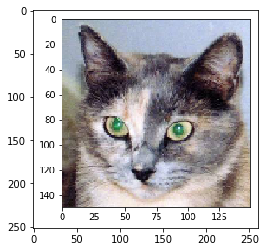

In [7]:
# let's look at the image
imgplot = plt.imshow(img)

#### Visualizing the different channels

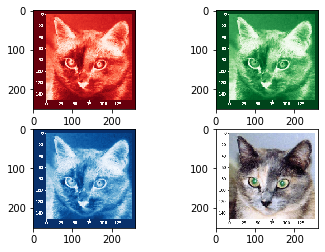

In [8]:
colors = [plt.cm.Reds, plt.cm.Greens, plt.cm.Blues, plt.cm.Greys]
subplots = np.arange(221,224)
for i in range(3):
    plt.subplot(subplots[i])
    plt.imshow(img[:,:,i], cmap=colors[i])
plt.subplot(224)
plt.imshow(img) 
plt.show()

If you want to learn more: [Image Processing with Python and Scipy](http://prancer.physics.louisville.edu/astrowiki/index.php/Image_processing_with_Python_and_SciPy)

## Part 3: Putting the Parts together to make a small ConvNet Model

Let's put all the parts together to make a convnet for classifying our good old MNIST digits.

In [9]:
# Load data and preprocess
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data(
    path='mnist.npz') # load MNIST data
train_images.shape

(60000, 28, 28)

**Notice:** These photos do not have a third dimention channel because they are B&W.

In [10]:
train_images.max(), train_images.min()

(255, 0)

In [11]:
train_images = train_images.reshape((60000, 28, 28, 1)) # Reshape to get third dimension
test_images = test_images.reshape((10000, 28, 28, 1)) 

train_images = train_images.astype('float32') / 255 # Normalize between 0 and 1
test_images = test_images.astype('float32') / 255 

# Convert labels to categorical data 
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [12]:
mnist_cnn_model = Sequential() # Create sequential model

# Add network layers
mnist_cnn_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
mnist_cnn_model.add(MaxPooling2D((2, 2)))
mnist_cnn_model.add(Conv2D(64, (3, 3), activation='relu')) 
mnist_cnn_model.add(MaxPooling2D((2, 2)))
mnist_cnn_model.add(Conv2D(64, (3, 3), activation='relu'))

The next step is to feed the last output tensor (of shape (3, 3, 64)) into a densely connected classifier network like those you’re already familiar with: a stack of Dense layers. These classifiers process vectors, which are 1D, whereas the output of the last conv layer is a 3D tensor. First we have to flatten the 3D outputs to 1D, and then add a few Dense layers on top.

In [13]:
mnist_cnn_model.add(Flatten())
mnist_cnn_model.add(Dense(32, activation='relu'))
mnist_cnn_model.add(Dense(10, activation='softmax'))
mnist_cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                1

<div class="Question"><b>Question</b> Why are we using cross-entropy here?</div>

In [14]:
loss = tf.keras.losses.categorical_crossentropy

optimizer = Adam(lr=0.001)

#optimizer = RMSprop(lr=1e-2)
# see https://www.tensorflow.org/api_docs/python/tf/keras/metrics
metrics = ['accuracy'] 

# Compile model
mnist_cnn_model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

<div class="discussion"><b>Discussion</b> How can we choose the batch size?</div>

In [15]:
%%time 

# Fit the model 
verbose, epochs, batch_size = 1, 10, 64 # try a different num epochs and batch size : 30, 16 
history = mnist_cnn_model.fit(train_images, train_labels, 
                              epochs=epochs, 
                              batch_size=batch_size, 
                              verbose=verbose,
                              validation_split=0.2,
                              # validation_data=(X_val, y_val) # IF you have val data
                              shuffle=True)

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 22s 458us/sample - loss: 0.2316 - accuracy: 0.9293 - val_loss: 0.0726 - val_accuracy: 0.9778
Epoch 2/10
48000/48000 [==============================] - 22s 453us/sample - loss: 0.0597 - accuracy: 0.9814 - val_loss: 0.0502 - val_accuracy: 0.9856
Epoch 3/10
48000/48000 [==============================] - 22s 465us/sample - loss: 0.0409 - accuracy: 0.9875 - val_loss: 0.0612 - val_accuracy: 0.9816
Epoch 4/10
48000/48000 [==============================] - 22s 463us/sample - loss: 0.0328 - accuracy: 0.9896 - val_loss: 0.0467 - val_accuracy: 0.9862
Epoch 5/10
48000/48000 [==============================] - 22s 458us/sample - loss: 0.0259 - accuracy: 0.9915 - val_loss: 0.0367 - val_accuracy: 0.9893
Epoch 6/10
48000/48000 [==============================] - 21s 446us/sample - loss: 0.0213 - accuracy: 0.9932 - val_loss: 0.0380 - val_accuracy: 0.9891
Epoch 7/10
48000/48000 [====================

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
0.99083334


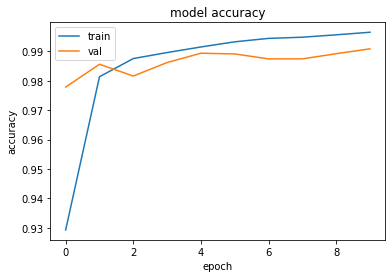

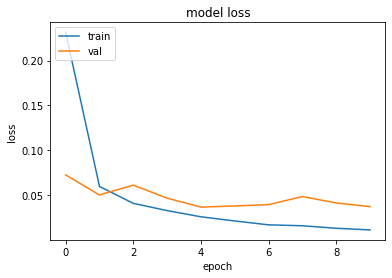

In [16]:
print(history.history.keys())
print(history.history['val_accuracy'][-1])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
#plt.savefig('../images/batch8.png')

In [17]:
mnist_cnn_model.metrics_names

['loss', 'accuracy']

In [18]:
#  Evaluate the model on the test data:
score = mnist_cnn_model.evaluate(test_images, test_labels, 
                       batch_size=batch_size, 
                       verbose=0, callbacks=None)
print("%s: %.2f%%" % (mnist_cnn_model.metrics_names[1], score[1]*100))
test_acc = mnist_cnn_model.evaluate(test_images, test_labels)
test_acc

accuracy: 99.14%
10000/1 [==============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.033168518798460035, 0.9914]

<div class="discussion"><b>Discussion</b> Compare validation accuracy and test accuracy? Comment on whether we have overfitting.</div>

### Data Preprocessing : Meet the `ImageDataGenerator` class in `keras` 


[(keras ImageGenerator documentation)](https://keras.io/preprocessing/image/)

The MNIST and other pre-loaded dataset are formatted in a way that is almost ready for feeding into the model. What about plain images? They should be formatted into appropriately preprocessed floating-point tensors before being fed into the network.

The Dogs vs. Cats dataset that you’ll use isn’t packaged with Keras. It was made available by Kaggle as part of a computer-vision competition in late 2013, back when convnets weren’t mainstream. The data has been downloaded for you from https://www.kaggle.com/c/dogs-vs-cats/data The pictures are medium-resolution color JPEGs.  

In [19]:
# TODO: set your base dir to your correct local location
base_dir = '../data/cats_and_dogs_small'

import os, shutil

# Set up directory information

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

test_cats_dir = os.path.join(test_dir, 'cats')
test_dogs_dir = os.path.join(test_dir, 'dogs')

print('total training cat images:', len(os.listdir(train_cats_dir))) 
print('total training dog images:', len(os.listdir(train_dogs_dir))) 
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))
print('total test cat images:', len(os.listdir(test_cats_dir))) 
print('total test dog images:', len(os.listdir(test_dogs_dir))) 

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
total test cat images: 500
total test dog images: 500


So you do indeed have 2,000 training images, 1,000 validation images, and 1,000 test images. Each split contains the same number of samples from each class: this is a balanced binary-classification problem, which means classification accuracy will be an appropriate measure of success.

<div class="discussion"><b>Discussion</b> Should you always do your own splitting of the data How about shuffling? Does it always make sense?</div>

In [21]:
img_path = '../data/cats_and_dogs_small/train/cats/cat.70.jpg'

# We preprocess the image into a 4D tensor
from tensorflow.keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
# Remember that the model was trained on inputs
# that were preprocessed in the following way:
img_tensor /= 255.

# Its shape is (1, 150, 150, 3)
print(img_tensor.shape)

(1, 150, 150, 3)


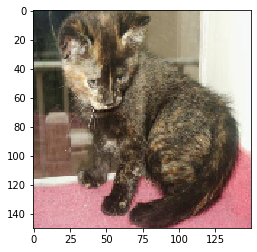

In [22]:
plt.imshow(img_tensor[0])
plt.show()

Why do we need an extra dimension here?

#### Building the network

In [23]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 15, 15, 128)      

For the compilation step, you’ll go with the RMSprop optimizer. Because you ended the network with a single sigmoid unit, you’ll use binary crossentropy as the loss.

In [24]:
loss = tf.keras.losses.binary_crossentropy
#optimizer = Adam(lr=0.001)

optimizer = RMSprop(lr=1e-2)

metrics = ['accuracy'] 

# Compile model
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

The steps for getting it into the network are roughly as follows:

1. Read the picture files.
2. Convert the JPEG content to RGB grids of pixels. 
3. Convert these into floating-point tensors.
4. Rescale the pixel values (between 0 and 255) to the [0, 1] interval (as you know, neural networks prefer to deal with small input values).

It may seem a bit daunting, but fortunately Keras has utilities to take care of these steps automatically with the class `ImageDataGenerator`, which lets you quickly set up Python generators that can automatically turn image files on disk into batches of preprocessed tensors. This is what you’ll use here.

In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Let’s look at the output of one of these generators: it yields batches of  150×150 RGB images (shape (20, 150, 150, 3)) and binary labels (shape (20,)). There are 20 samples in each batch (the batch size). Note that the generator yields these batches indefinitely: it loops endlessly over the images in the target folder. For this reason, you need to break the iteration loop at some point:

In [26]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


Let’s fit the model to the data using the generator. You do so using the `.fit_generator` method, the equivalent of `.fit` for data generators like this one. It expects as its first argument a Python generator that will yield batches of inputs and targets indefinitely, like this one does. 

Because the data is being generated endlessly, the Keras model needs to know how many samples to draw from the generator before declaring an epoch over. This is the role of the `steps_per_epoch` argument: after having drawn steps_per_epoch batches from the generator—that is, after having run for steps_per_epoch gradient descent steps - the fitting process will go to the next epoch. In this case, batches are 20 samples, so it will take 100 batches until you see your target of 2,000 samples.

When using fit_generator, you can pass a validation_data argument, much as with the fit method. It’s important to note that this argument is allowed to be a data generator, but it could also be a tuple of Numpy arrays. If you pass a generator as validation_data, then this generator is expected to yield batches of validation data endlessly; thus you should also specify the validation_steps argument, which tells the process how many batches to draw from the validation generator for evaluation

In [27]:
%%time 
# Fit the model <--- always a good idea to time it 
verbose, epochs, batch_size, steps_per_epoch = 1, 5, 64, 100

history = model.fit_generator(
      train_generator,
      steps_per_epoch=steps_per_epoch,
      epochs=5, # TODO: should be 100
      validation_data=validation_generator,
      validation_steps=50)


# It’s good practice to always save your models after training.
model.save('cats_and_dogs_small_1.h5')

Epoch 1/5
100/100 [==============================] - 97s 966ms/step - loss: 7.6198 - accuracy: 0.5000 - val_loss: 7.6666 - val_accuracy: 0.5000
Epoch 2/5
100/100 [==============================] - 88s 879ms/step - loss: 7.6666 - accuracy: 0.5000 - val_loss: 7.6666 - val_accuracy: 0.5000
Epoch 3/5
100/100 [==============================] - 89s 886ms/step - loss: 7.6666 - accuracy: 0.5000 - val_loss: 7.6666 - val_accuracy: 0.5000
Epoch 4/5
100/100 [==============================] - 95s 945ms/step - loss: 7.6666 - accuracy: 0.5000 - val_loss: 7.6666 - val_accuracy: 0.5000
Epoch 5/5
100/100 [==============================] - 94s 937ms/step - loss: 7.6666 - accuracy: 0.5000 - val_loss: 7.6666 - val_accuracy: 0.5000
CPU times: user 43min 45s, sys: 4min 43s, total: 48min 28s
Wall time: 7min 41s


Let’s plot the loss and accuracy of the model over the training and validation data during training:

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
0.5


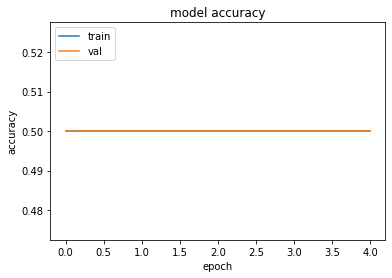

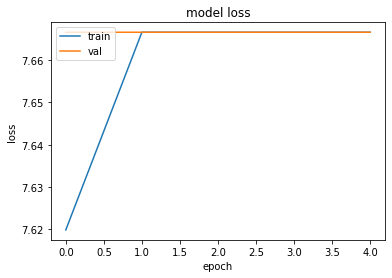

<Figure size 432x288 with 0 Axes>

In [28]:
print(history.history.keys())
print(history.history['val_accuracy'][-1])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.savefig('../images/batch8.png')

Let's try data augmentation

In [82]:
datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

These are just a few of the options available (for more, see the Keras documentation). 
Let’s quickly go over this code:

- rotation_range is a value in degrees (0–180), a range within which to randomly rotate pictures.
- width_shift and height_shift are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally.
- shear_range is for randomly applying shearing transformations.
- zoom_range is for randomly zooming inside pictures.
- horizontal_flip is for randomly flipping half the images horizontally—relevant when there are no assumptions of - horizontal asymmetry (for example, real-world pictures).
- fill_mode is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift. 

Let’s look at the augmented images

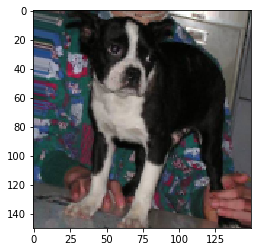

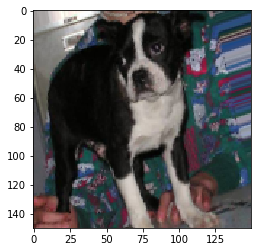

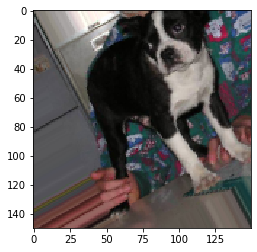

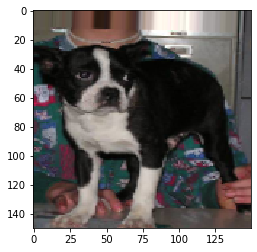

In [83]:
from keras.preprocessing import image
fnames = [os.path.join(train_dogs_dir, fname) for
     fname in os.listdir(train_dogs_dir)]
img_path = fnames[3] # Chooses one image to augment
img = image.load_img(img_path, target_size=(150, 150))
# Reads the image and resizes it
x = image.img_to_array(img) # Converts it to a Numpy array with shape (150, 150, 3) 
x = x.reshape((1,) + x.shape) # Reshapes it to (1, 150, 150, 3)
i=0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

If you train a new network using this data-augmentation configuration, the network will never see the same input twice. But the inputs it sees are still heavily intercorrelated, because they come from a small number of original images—you can’t produce new information, you can only remix existing information. As such, this may not be enough to completely get rid of overfitting. To further fight overfitting, you’ll also add a **Dropout** layer to your model right before the densely connected classifier.

In [84]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 15, 15, 128)      

In [85]:
loss = tf.keras.losses.binary_crossentropy
optimizer = RMSprop(lr=1e-4)
metrics = ['acc', 'accuracy'] 

# Compile model
model.compile(loss=loss,
              optimizer=optimizer,
              metrics=metrics)

In [86]:
# Let’s train the network using data augmentation and dropout.
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

test_datagen = ImageDataGenerator(rescale=1./255)

# Note that the validation data shouldn’t be augmented!
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=5, # TODO: should be 100
      validation_data=validation_generator,
      validation_steps=50)

# save model if needed
model.save('cats_and_dogs_small_2.h5')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 100 steps, validate for 50 steps
Epoch 1/5
 63/100 [=================>............] - ETA: 22s - loss: 0.6958 - acc: 0.5100 - accuracy: 0.5100WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 500 batches). You may need to use the repeat() function when building your dataset.


And let’s plot the results again. Thanks to data augmentation and dropout, you’re no longer overfitting: the training curves are closely tracking the validation curves. You now reach an accuracy of 82%, a 15% relative improvement over the non-regularized model. (Note: these numbers are for 100 epochs..)

dict_keys(['val_loss', 'val_acc', 'val_accuracy', 'loss', 'acc', 'accuracy'])
0.6040608882904053


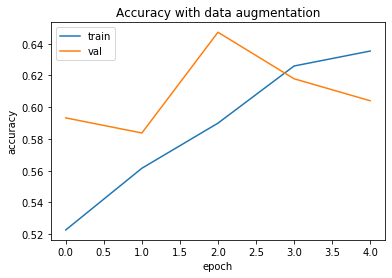

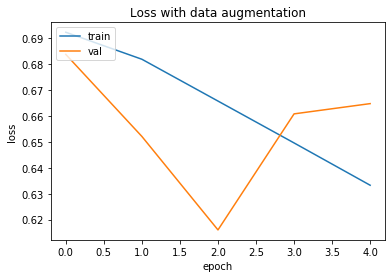

In [44]:
print(history.history.keys())
print(history.history['val_accuracy'][-1])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy with data augmentation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss with data augmentation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
#plt.savefig('../images/batch8.png')

By using regularization techniques even further, and by tuning the network’s parameters (such as the number of filters per convolution layer, or the number of layers in the network), you may be able to get an even better accuracy, likely up to 86% or 87%. But it would prove difficult to go any higher just by training your own convnet from scratch, because you have so little data to work with. As a next step to improve your accuracy on this problem, you’ll have to use a pretrained model.